In [ ]:
import matplotlib.pyplot as plt
from exact import exact
from sampling import sampling

### Exact Algorithm

In [ ]:
# gather frequency of all items for each dataset
accidents_freq = exact(0, "./datasets/accidents.dat")
kosarak_freq = exact(0, "./datasets/kosarak.dat")
webdocs_freq = exact(0, "./datasets/webdocs.dat")


In [49]:
def visualize(dataset: str, freq: list[tuple[int, float]]):
    # keys:values = frequency threshold:|F(D,thres)|/|I|
    dist = {}
    for i in range(len(freq)-1,-1,-1):
        dist[freq[i][1]] = (len(freq) - 1 - i) / len(freq)

    # plot frequency distribution
    plt.scatter(dist.keys(), dist.values())
    plt.title(f"{dataset}.dat")
    plt.xlabel("threshold")
    # plt.xscale('log')
    plt.ylabel("|F(D,threshold)| / |I|")

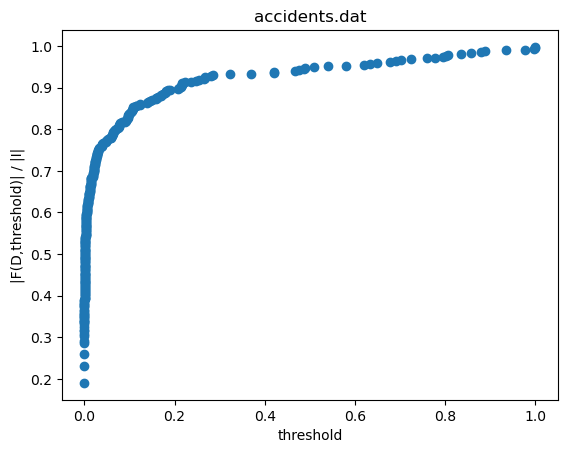

In [50]:
visualize("accidents", accidents_freq)

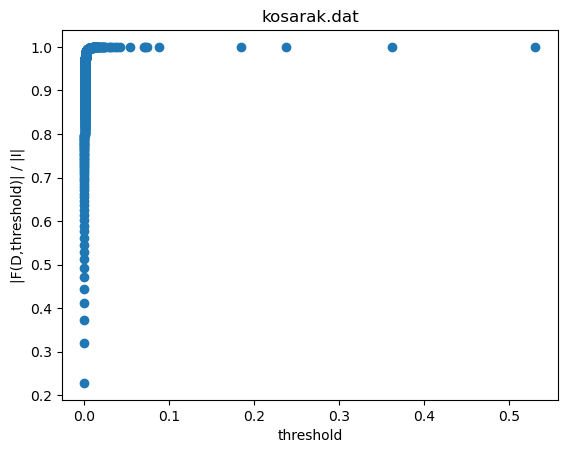

In [51]:
visualize("kosarak", kosarak_freq)

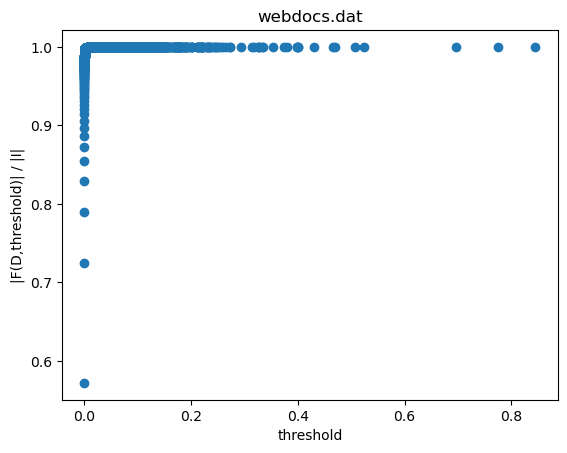

In [52]:
visualize("webdocs", webdocs_freq)

FILL IN: analysis of frequency distributions for exact algorithm

### Sampling-based Algorithm